# 1. Project Objective

The goal of this project is to analyze the Steam games dataset to identify **which games offer the best and worst value for money**.

More specifically, we aim to:
- Measure the relationship between a game's **price** and its **average playtime**.
- Detect games that provide **high entertainment per euro spent**.
- Highlight games that are **expensive but rarely played**.
- Group similar games using **unsupervised learning techniques** (clustering).

This insight can help players discover hidden gems and avoid overpriced, underplayed titles.

We will use basic data cleaning, feature engineering (e.g., playtime-to-price ratio), and clustering (e.g., K-Means) to visualize and segment the games accordingly.


# 2. Dataset

In [68]:
# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML and Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

# Plot settings
sns.set(style='whitegrid')
%matplotlib inline

# Display files inside the input directory
import os

print("Available input files:")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print("  -", os.path.join(dirname, filename))


Available input files:
  - /kaggle/input/steam-store-games/steam_support_info.csv
  - /kaggle/input/steam-store-games/steam_media_data.csv
  - /kaggle/input/steam-store-games/steamspy_tag_data.csv
  - /kaggle/input/steam-store-games/steam_requirements_data.csv
  - /kaggle/input/steam-store-games/steam_description_data.csv
  - /kaggle/input/steam-store-games/steam.csv


In [69]:
# Load the main dataset
df = pd.read_csv('/kaggle/input/steam-store-games/steam.csv')

# Dataset dimensions
print("Shape:", df.shape)

# Preview first rows
df.head()



Shape: (27075, 18)


,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


# 3. Data Preprocessing

In this section, we will clean and prepare the dataset by:
- Selecting the relevant features for our analysis
- Handling missing or inconsistent values
- Creating a new feature to represent the value-for-money ratio
- Filtering out irrelevant entries (e.g., non-playable or free games with no playtime)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27075 entries, 0 to 27074
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   appid             27075 non-null  int64  
 1   name              27075 non-null  object 
 2   release_date      27075 non-null  object 
 3   english           27075 non-null  int64  
 4   developer         27074 non-null  object 
 5   publisher         27061 non-null  object 
 6   platforms         27075 non-null  object 
 7   required_age      27075 non-null  int64  
 8   categories        27075 non-null  object 
 9   genres            27075 non-null  object 
 10  steamspy_tags     27075 non-null  object 
 11  achievements      27075 non-null  int64  
 12  positive_ratings  27075 non-null  int64  
 13  negative_ratings  27075 non-null  int64  
 14  average_playtime  27075 non-null  int64  
 15  median_playtime   27075 non-null  int64  
 16  owners            27075 non-null  object

In [71]:
# Select relevant columns
df_selected = df[['name', 'price', 'average_playtime', 'positive_ratings', 'negative_ratings']]
df_selected.head()

,name,price,average_playtime,positive_ratings,negative_ratings
0,Counter-Strike,7.19,17612,124534,3339
1,Team Fortress Classic,3.99,277,3318,633
2,Day of Defeat,3.99,187,3416,398
3,Deathmatch Classic,3.99,258,1273,267
4,Half-Life: Opposing Force,3.99,624,5250,288


In [72]:
# Remove free games
df_selected = df_selected[df_selected['price'] > 0]

# Remove games with no playtime
df_selected = df_selected[df_selected['average_playtime'] > 0]

# Drop duplicates based on game name
df_selected = df_selected.drop_duplicates(subset='name')

print("Remaining entries after filtering:", df_selected.shape)


Remaining entries after filtering: (5348, 5)


In [73]:
# Add value_per_euro feature
df_selected['value_per_euro'] = df_selected['average_playtime'] / df_selected['price']

# Check distribution
df_selected[['value_per_euro']].describe()


,value_per_euro
count,5348.000000
mean,110.860772
std,615.175801
min,0.016396
25%,13.208806
50%,40.343348
75%,98.608275
max,32046.835443


In [74]:
# Check for missing values
df_selected.isnull().sum()

name                0
price               0
average_playtime    0
positive_ratings    0
negative_ratings    0
value_per_euro      0
dtype: int64

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


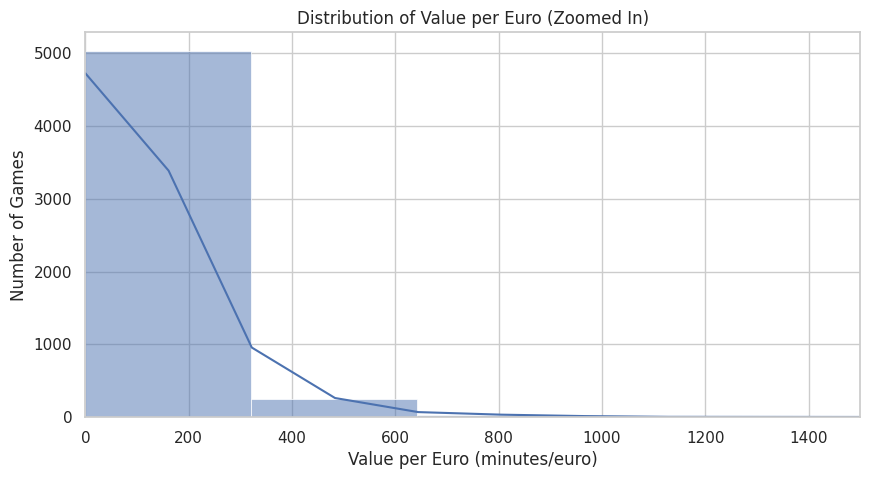

In [75]:
plt.figure(figsize=(10, 5))
sns.histplot(df_selected['value_per_euro'], bins=100, kde=True)
plt.xlim(0, 1500)
plt.title('Distribution of Value per Euro (Zoomed In)')
plt.xlabel('Value per Euro (minutes/euro)')
plt.ylabel('Number of Games')
plt.show()


In [76]:
# Trim extreme outliers based on value_per_euro
low, high = df_selected['value_per_euro'].quantile([0.01, 0.99])
df_filtered = df_selected[(df_selected['value_per_euro'] >= low) & (df_selected['value_per_euro'] <= high)]

print("Entries after trimming outliers:", df_filtered.shape)


Entries after trimming outliers: (5240, 6)


In [77]:
features = df_filtered[['value_per_euro', 'price', 'average_playtime']].copy()

# Optional: standardize the features before clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


# 4. Dimensionality Reduction

To better visualize and understand the structure of our data, we will reduce the number of features from 3 to 2 using dimensionality reduction techniques.

Although we are working with just three variables (`value_per_euro`, `price`, and `average_playtime`), plotting them in 2D helps us:

- Detect natural groupings visually
- Prepare the data for clustering
- Spot potential outliers or anomalies

We will use:
- **PCA (Principal Component Analysis):** A linear method that captures the directions of greatest variance.

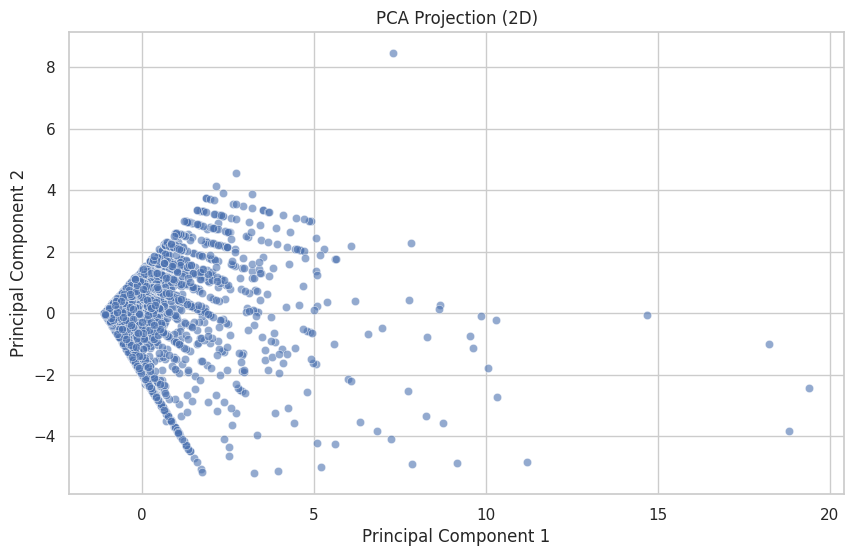

In [78]:
from sklearn.decomposition import PCA

# Reduce to 2 dimensions with PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Add PCA results to the dataframe
df_filtered = df_filtered.copy()
df_filtered['PCA1'] = pca_result[:, 0]
df_filtered['PCA2'] = pca_result[:, 1]

# Visualize the PCA projection
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtered, x='PCA1', y='PCA2', alpha=0.6)
plt.title('PCA Projection (2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


We reduce the dataset to 2 principal components using PCA to visualize the overall structure of the data. This helps us observe whether natural clusters or separable regions exist before applying any clustering algorithm.


# 5. Clustering Models

In this section, we will:

- Use the **K-Means algorithm** to automatically assign each game to a cluster
- Test different values of `k` (number of clusters) and evaluate them using the **Silhouette Score**
- Visualize the resulting clusters using our PCA projection

This will help us uncover meaningful patterns, such as:
- Games that are cheap but highly engaging
- Games that are expensive but underplayed
- Groups of similar value-price relationships

Let's begin by choosing the optimal number of clusters.


In [79]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Test different values of k
k_values = range(2, 11)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(scaled_features)
    score = silhouette_score(scaled_features, labels)
    silhouette_scores.append(score)
    print(f"k = {k} → Silhouette Score: {score:.4f}")


k = 2 → Silhouette Score: 0.5697
k = 3 → Silhouette Score: 0.5792
k = 4 → Silhouette Score: 0.5577
k = 5 → Silhouette Score: 0.4428
k = 6 → Silhouette Score: 0.4465
k = 7 → Silhouette Score: 0.4220
k = 8 → Silhouette Score: 0.4242
k = 9 → Silhouette Score: 0.4255
k = 10 → Silhouette Score: 0.4269


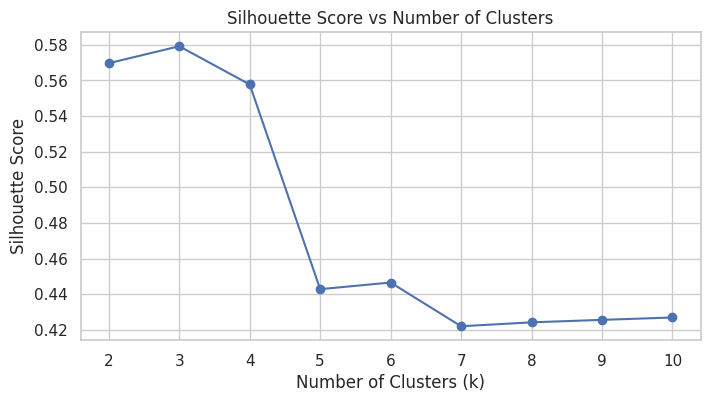

In [80]:
plt.figure(figsize=(8, 4))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


To determine the optimal number of clusters for K-Means, we tested values of `k` from 2 to 10 and evaluated each using the **Silhouette Score**. This score measures how well-separated the clusters are, with higher values indicating better-defined groups.

The highest Silhouette Score was obtained with **k = 3**, which suggests that the data naturally groups into three distinct clusters.

In [81]:
# Apply K-Means with the optimal number of clusters
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(scaled_features)

# Add cluster labels to dataframe
df_filtered['cluster'] = cluster_labels


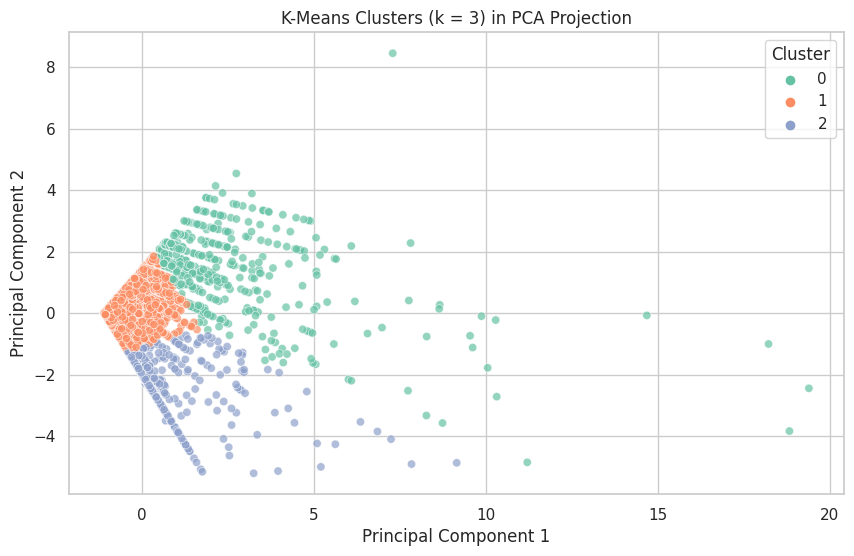

In [82]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_filtered,
    x='PCA1',
    y='PCA2',
    hue='cluster',
    palette='Set2',
    alpha=0.7
)
plt.title('K-Means Clusters (k = 3) in PCA Projection')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


# 6. Cluster Evaluation

Now that the clustering is complete, it's time to understand what each cluster represents.

In this section, we will:

- Analyze the **average values of `price`, `average_playtime`, and `value_per_euro`** for each cluster
- Identify the **profile of each group**: Are they cheap and engaging games? Expensive but underplayed? Or somewhere in between?

By doing this, we can give meaning to the clusters discovered by K-Means and evaluate whether they align with our goal of identifying value-for-money patterns in Steam games.


In [83]:
# Group by cluster and calculate mean values
cluster_summary = df_filtered.groupby('cluster')[['price', 'average_playtime', 'value_per_euro']].mean().round(2)

# Add count of games in each cluster
cluster_summary['count'] = df_filtered['cluster'].value_counts().sort_index()

cluster_summary


,price,average_playtime,value_per_euro,count
cluster,,,,
0,28.91,1874.24,77.48,462
1,7.43,244.06,43.57,4096
2,1.89,581.80,309.19,682


# 7. Cluster Interpretation

Based on the statistical summary of each cluster, we can now assign meaning to the groups discovered by K-Means.

Here's a breakdown of what each cluster represents:

| Cluster | 💰 Avg. Price | 🕹️ Avg. Playtime | 💎 Value per Euro | 🎮 Games | Description |
|---------|---------------|------------------|-------------------|---------|-------------|
| **0**   | 28.91 €        | 1,874 min         | 77.48             | 462     | **Premium games**: expensive, long playtime, but moderate value-for-money. Likely AAA titles or story-rich games. |
| **1**   | 7.43 €         | 244 min           | 43.57             | 4,096   | **Low-retention games**: mid-priced, low engagement. These might be average or niche games with poor replayability. |
| **2**   | 1.89 €         | 581 min           | 309.19            | 682     | **High-value gems**: cheap games that deliver a lot of playtime. Likely indie hits or popular multiplayer games. |

---

### 🎯 Insights:

- The best value-for-money games belong to **Cluster 2**.
- **Cluster 0** includes big titles with long campaigns, but less efficient in terms of €/minute.
- Games in **Cluster 1** may be overpriced for what they offer and represent potential overhyped or underdeveloped titles.

These clusters could be very useful for players looking for cost-effective entertainment or for developers analyzing how pricing and engagement relate.

Next, we’ll conclude with final observations.


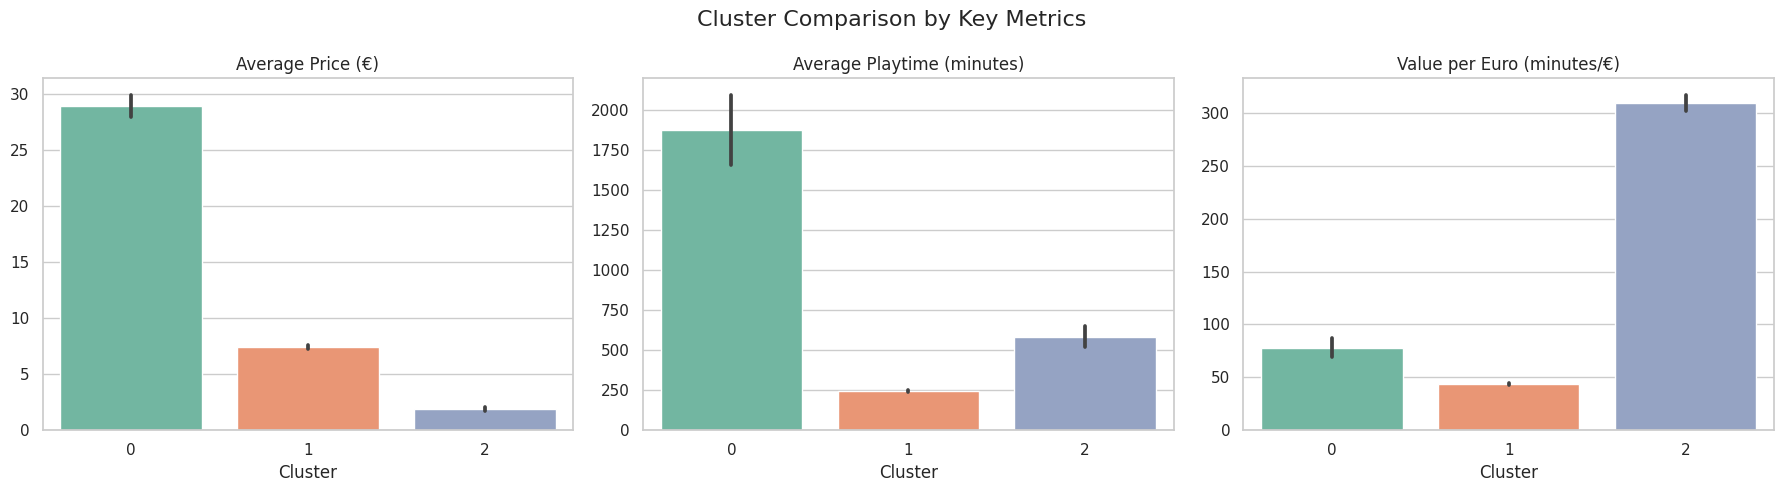

In [84]:
import matplotlib.pyplot as plt

# Variables a mostrar
metrics = ['price', 'average_playtime', 'value_per_euro']
titles = ['Average Price (€)', 'Average Playtime (minutes)', 'Value per Euro (minutes/€)']

# Crear subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, metric in enumerate(metrics):
    sns.barplot(
        data=df_filtered,
        x='cluster',
        y=metric,
        ax=axes[i],
        palette='Set2'
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel('')

plt.suptitle('Cluster Comparison by Key Metrics', fontsize=16)
plt.tight_layout()
plt.show()


To better understand the differences between clusters, this bar charts compare the average **price**, **playtime**, and **value per euro** for each group.

This visual summary reinforces our previous interpretation:

- **Cluster 2** stands out as the most cost-efficient group (cheap games with lots of playtime).
- **Cluster 0** includes more expensive games with long sessions, but lower value per euro.
- **Cluster 1** shows low engagement despite mid-range prices — possibly the least efficient group.



# 8. Conclusion

In [85]:
# Top 10 games with highest value per euro (from best cluster)
top_value_games = df_filtered[df_filtered['cluster'] == 2].sort_values(
    by='value_per_euro', ascending=False
)[['name', 'price', 'average_playtime', 'value_per_euro']].head(10)

top_value_games


,name,price,average_playtime,value_per_euro
13492,Live Wallpaper Master,2.89,2129,736.678201
3418,Asteria,3.99,2908,728.822055
6287,Alpha Runner,0.79,574,726.582278
4314,Catmouth Island,0.79,565,715.189873
7338,The Madness of Little Emma,5.99,4277,714.023372
1025,The Elder Scrolls V: Skyrim,9.99,7089,709.609610
640,Arma 2: Operation Arrowhead,11.99,8488,707.923269
12710,Queen of Seas,0.79,540,683.544304
5953,Mortos,0.79,525,664.556962
216,RACE 07,2.49,1636,657.028112


In this project, we explored a key question for any Steam user:

> **Which games offer the best value for money?**

Using unsupervised learning and clustering techniques, we analyzed over 27,000 Steam titles and segmented them based on their **price**, **average playtime**, and a derived metric: **value per euro** (minutes played per euro spent).

---

### 🔍 What We Did:

- Cleaned and filtered the dataset to remove free games, unplayed titles, and outliers
- Engineered a custom `value_per_euro` feature
- Applied **PCA** for dimensionality reduction and visual understanding
- Used **K-Means clustering** to group games into 3 distinct clusters
- Evaluated each cluster to understand their profile:
  - **Cluster 0**: Premium titles — expensive, long, moderate value
  - **Cluster 1**: Low-retention — average price, low engagement
  - **Cluster 2**: High-value gems — low price, high engagement

---

### 🧠 Key Insight:

**Not all cheap games are valuable, and not all expensive games are wasteful.**  

---

### 🏆 Top 10 Games with Highest Value per Euro

This list includes some surprising entries — from indie curiosities to legendary open-world games. All values were calculated based on playtime and cost, but we've highlighted the ones truly worth your time:

| Game Name                       | Price (€) | Avg. Playtime (min) | Value per Euro |
|--------------------------------|-----------|----------------------|----------------|
| Live Wallpaper Master ⚠️        | 2.89      | 2,129                | 736.68         |
| Asteria 🟡                       | 3.99      | 2,908                | 728.82         |
| Alpha Runner ❌                 | 0.79      | 574                  | 726.58         |
| Catmouth Island ❌              | 0.79      | 565                  | 715.19         |
| **The Madness of Little Emma ✅** | 5.99      | 4,277                | 714.02         |
| **The Elder Scrolls V: Skyrim ✅** | 9.99      | 7,089                | 709.61         |
| **Arma 2: Operation Arrowhead ✅** | 11.99     | 8,488                | 707.92         |
| Queen of Seas ❌                | 0.79      | 540                  | 683.54         |
| Mortos ❌                       | 0.79      | 525                  | 664.56         |
| **RACE 07 ✅**                   | 2.49      | 1,636                | 657.03         |

> ✅ Recommended titles worth exploring  
> ❌ Entries with questionable gameplay or limited impact  
> 🟡 Niche indie titles with some potential  
> ⚠️ Non-game utility (technically valid, but not for gaming)

---

### 🎯 Final Thoughts

This project demonstrates how even a simple metric like playtime-per-euro can reveal powerful insights — but also the importance of combining **quantitative analysis with context and domain knowledge**.

For future work, we could:
- Integrate **user reviews**, **Steam tags**, or **playtime distributions**
- Weight `value_per_euro` by **popularity or satisfaction**
- Build a **recommendation system** based on cluster proximity

Until then, this notebook offers a useful tool for discovering high-value games — and for thinking critically about what "value" really means in the gaming world.
